# Importing the Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from time import time

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib

# Loading and Analyzing the Data

In [14]:
df_scraped = pd.read_csv('labeled_tweets.csv')
df_public = pd.read_csv('public_data_labeled.csv')

In [15]:
df_scraped

,id,label,full_text
0,572342978255048705,Offensive,So Drasko just said he was impressed the girls...
1,572342978255048705,Offensive,So Drasko just said he was impressed the girls...
2,572341498827522049,Offensive,Drasko they didn't cook half a bird you idiot ...
3,572341498827522049,Offensive,Drasko they didn't cook half a bird you idiot ...
4,572340476503724032,Offensive,Hopefully someone cooks Drasko in the next ep ...
...,...,...,...
11085,576255143101882368,Non-offensive,RT @Transition: @freebsdgirl just so I’m clear...
11086,576481461424934912,Non-offensive,RT @Leonard_Delaney: @freebsdgirl I know! Holy...
11087,576607445692256256,Non-offensive,"FLOSS Weekly, open source projects, and paying..."
11088,572268344394399744,Non-offensive,RT @Kasparov63: My WSJ article on Boris Nemtso...


Categorical Distributions

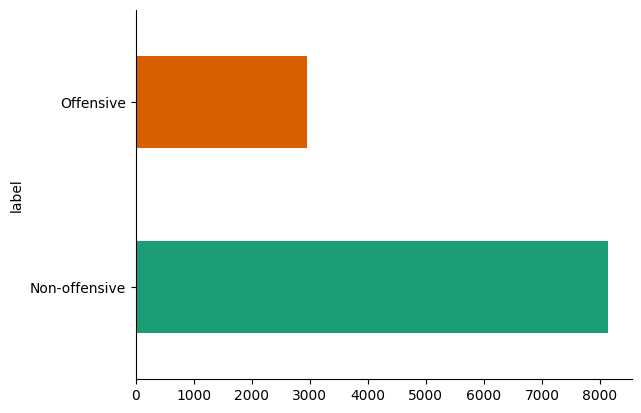

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns
df_scraped.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Faceted distributions

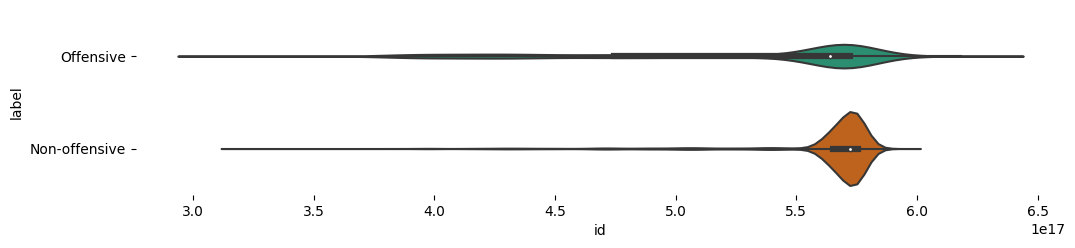

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_scraped['label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_scraped, x='id', y='label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [11]:
df_public

,label,full_text
0,Non-offensive,!!! RT @mayasolovely: As a woman you shouldn't...
1,Offensive,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,Offensive,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,Offensive,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,Offensive,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,Offensive,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,Non-offensive,"you've gone and broke the wrong heart baby, an..."
24780,Offensive,young buck wanna eat!!.. dat nigguh like I ain...
24781,Offensive,youu got wild bitches tellin you lies


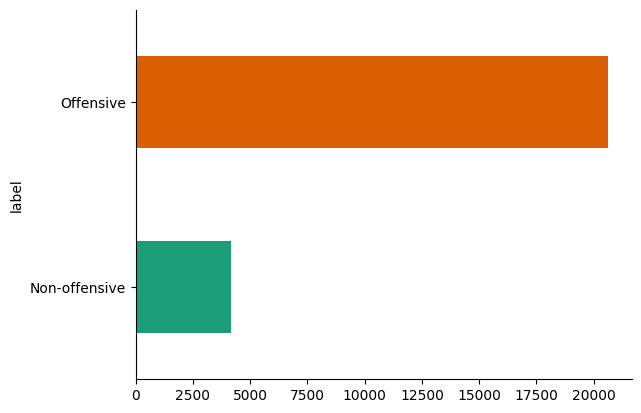

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns
df_public.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [16]:
df_scraped.drop_duplicates(inplace = True)
df_scraped.drop('id', axis = 'columns', inplace = True)

df_public.drop_duplicates(inplace = True)

In [17]:
df_scraped.head(2)

,label,full_text
0,Offensive,So Drasko just said he was impressed the girls...
2,Offensive,Drasko they didn't cook half a bird you idiot ...


In [18]:
df = pd.concat([df_scraped, df_public])

In [19]:
df.shape

(35787, 2)

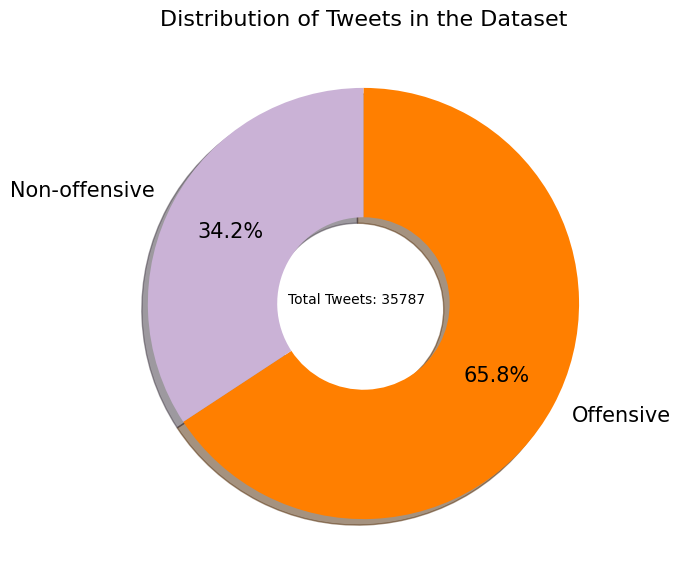

In [7]:
plt.figure(figsize = (7,7))
sorted_counts = df['label'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(df.shape[0]))
plt.title('Distribution of Tweets in the Dataset', fontsize = 16);

In [8]:
df['label'] = df.label.map({'Offensive': 1, 'Non-offensive': 0})

# Implementing a training and predicting Pipeline

Seperating Training and Testing Data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['full_text'],
                                                    df['label'],
                                                    random_state=42)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 35787
Number of rows in the training set: 26840
Number of rows in the test set: 8947


Vectorizing the Data

In [10]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer(stop_words = 'english', lowercase = True)

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_train)

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data = count_vector.transform(X_test)

Implementing the Pipeline

In [11]:
def pipeline(learner_list, X_train, y_train, X_test, y_test):
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''

    # Get length of Training Data:
    size = len(y_train)

    results = {}
    final_results = []

    for learner in learner_list:

        # Store the learner name:
        results['Algorithm'] = learner.__class__.__name__

        # Fit the learner:
        start = time() # Get start time
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(X_train, y_train)
        end = time() # Get end time

        # Store the training time
        results['Training Time'] = end - start

        start = time() # Get start time
        predictions_test = learner.predict(X_test)
        predictions_train = learner.predict(X_train)
        end = time() # Get end time

        # Store the prediction time
        results['Prediction Time'] = end - start

        # Compute the Accuracy on Test Set
        results['Accuracy: Test'] = accuracy_score(y_test, predictions_test)

        # Compute the Accuracy on Training Set
        results['Accuracy: Train'] = accuracy_score(y_train, predictions_train)

        # Compute the F1 Score on Test Set
        results['F1 Score: Test'] = f1_score(y_test, predictions_test)

        # Compute the F1 Score on Training Set
        results['F1 Score: Train'] = f1_score(y_train, predictions_train)

        # Compute the Precision on Test Set
        results['Precision: Test'] = precision_score(y_test, predictions_test)

        # Compute the Precision on Training Set
        results['Precision: Train'] = precision_score(y_train, predictions_train)

        # Compute the Recall on Test Set
        results['Recall: Test'] = recall_score(y_test, predictions_test)

        # Compute the Recall on Training Set
        results['Recall: Train'] = recall_score(y_train, predictions_train)

        # Success
        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('----------------------------------------------------')

        final_results.append(results.copy())
    # Return a dataframe of the results
    return final_results

Putting Algorithms in Pipeline

In [19]:
# make a list of models
models = [MultinomialNB(), DecisionTreeClassifier(), LinearSVC(), AdaBoostClassifier(),
          RandomForestClassifier(), BaggingClassifier(),
          SGDClassifier(), KNeighborsClassifier()]


In [20]:
print("NaN values in y_train:", y_train.isna().sum())
print("NaN values in y_test:", y_test.isna().sum())

NaN values in y_train: 0
NaN values in y_test: 0


In [21]:
re = pipeline(models, training_data, y_train, testing_data, y_test)
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

Training MultinomialNB
Training MultinomialNB finished in 0.02 sec
----------------------------------------------------
Training DecisionTreeClassifier
Training DecisionTreeClassifier finished in 5.01 sec
----------------------------------------------------
Training LinearSVC
Training LinearSVC finished in 0.59 sec
----------------------------------------------------
Training AdaBoostClassifier
Training AdaBoostClassifier finished in 1.90 sec
----------------------------------------------------
Training RandomForestClassifier
Training RandomForestClassifier finished in 78.24 sec
----------------------------------------------------
Training BaggingClassifier
Training BaggingClassifier finished in 39.77 sec
----------------------------------------------------
Training SGDClassifier
Training SGDClassifier finished in 0.11 sec
----------------------------------------------------
Training KNeighborsClassifier
Training KNeighborsClassifier finished in 0.00 sec
-------------------------------

In [22]:
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time','Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])
results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

# Analyse the Result of the Pipeline

In [23]:
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
0,SGDClassifier,0.928244,0.963048,0.926361,0.944348,0.002725,0.982712,0.992549,0.981078,0.986780,0.112476
1,BaggingClassifier,0.927015,0.962812,0.924660,0.943350,0.307706,0.988487,0.997247,0.985213,0.991194,39.768266
2,DecisionTreeClassifier,0.923773,0.955326,0.927381,0.941146,0.027097,0.998845,0.999943,0.998300,0.999121,5.012838
3,LinearSVC,0.916732,0.946599,0.925510,0.935936,0.002098,0.997019,0.998298,0.997167,0.997733,0.590208
4,RandomForestClassifier,0.915838,0.948243,0.922279,0.935081,3.860781,0.998845,0.999546,0.998697,0.999121,78.244517
5,AdaBoostClassifier,0.907567,0.972508,0.884354,0.926338,0.841120,0.909650,0.971744,0.888448,0.928231,1.899436
6,MultinomialNB,0.893372,0.901663,0.940306,0.920579,0.004964,0.944560,0.956763,0.959039,0.957900,0.015638
7,KNeighborsClassifier,0.857606,0.895161,0.887245,0.891186,31.728050,0.897727,0.927596,0.915982,0.921753,0.004611


In [24]:
results.describe().loc[['min', 'max'], :]

,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
min,0.857606,0.895161,0.884354,0.891186,0.002098,0.897727,0.927596,0.888448,0.921753,0.004611
max,0.928244,0.972508,0.940306,0.944348,31.728050,0.998845,0.999943,0.998697,0.999121,78.244517


In [25]:
# store the best metric scores
best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]

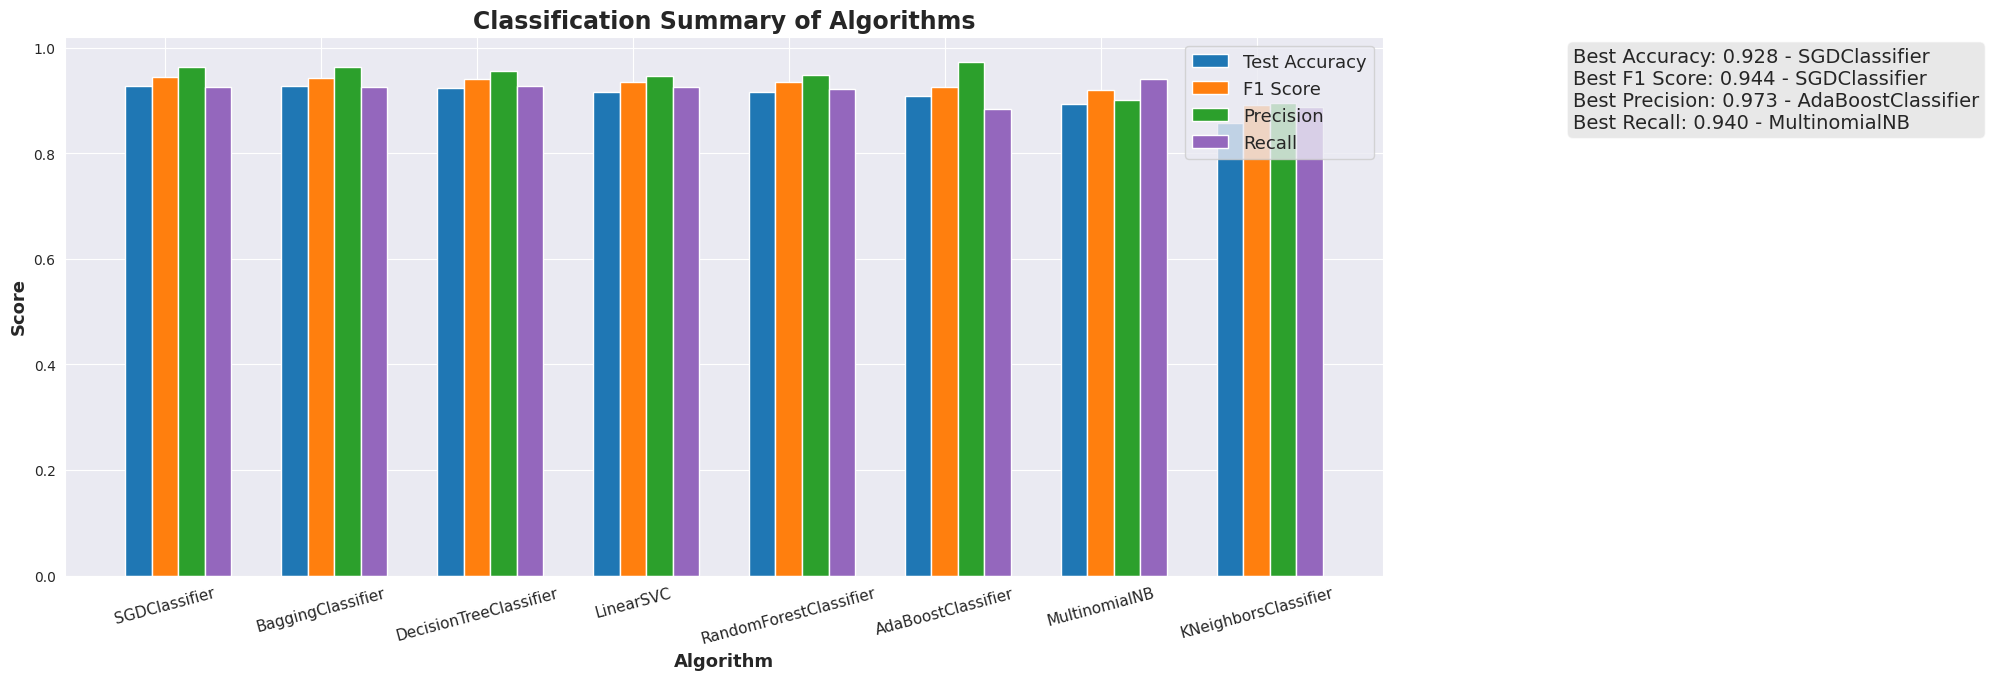

In [26]:
sns.set_style('darkgrid')
plt.figure(figsize = (17, 7))

barWidth = 0.17

# set height of bar
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']
bars3 = results['Precision: Test']
bars4 = results['Recall: Test']


# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]


# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')
plt.bar(r3, bars3, color= pal[2], width=barWidth, edgecolor='white', label='Precision')
plt.bar(r4, bars4, color= pal[4], width=barWidth, edgecolor='white', label='Recall')


# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)

# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]),
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0]),
                   'Best Precision: {:.3f} - {}'.format(best_precision['Precision: Test'].values[0], best_precision['Algorithm'].values[0]),
                    'Best Recall: {:.3f} - {}'.format(best_recall['Recall: Test'].values[0], best_recall['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9.2, 1, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

In [27]:
# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

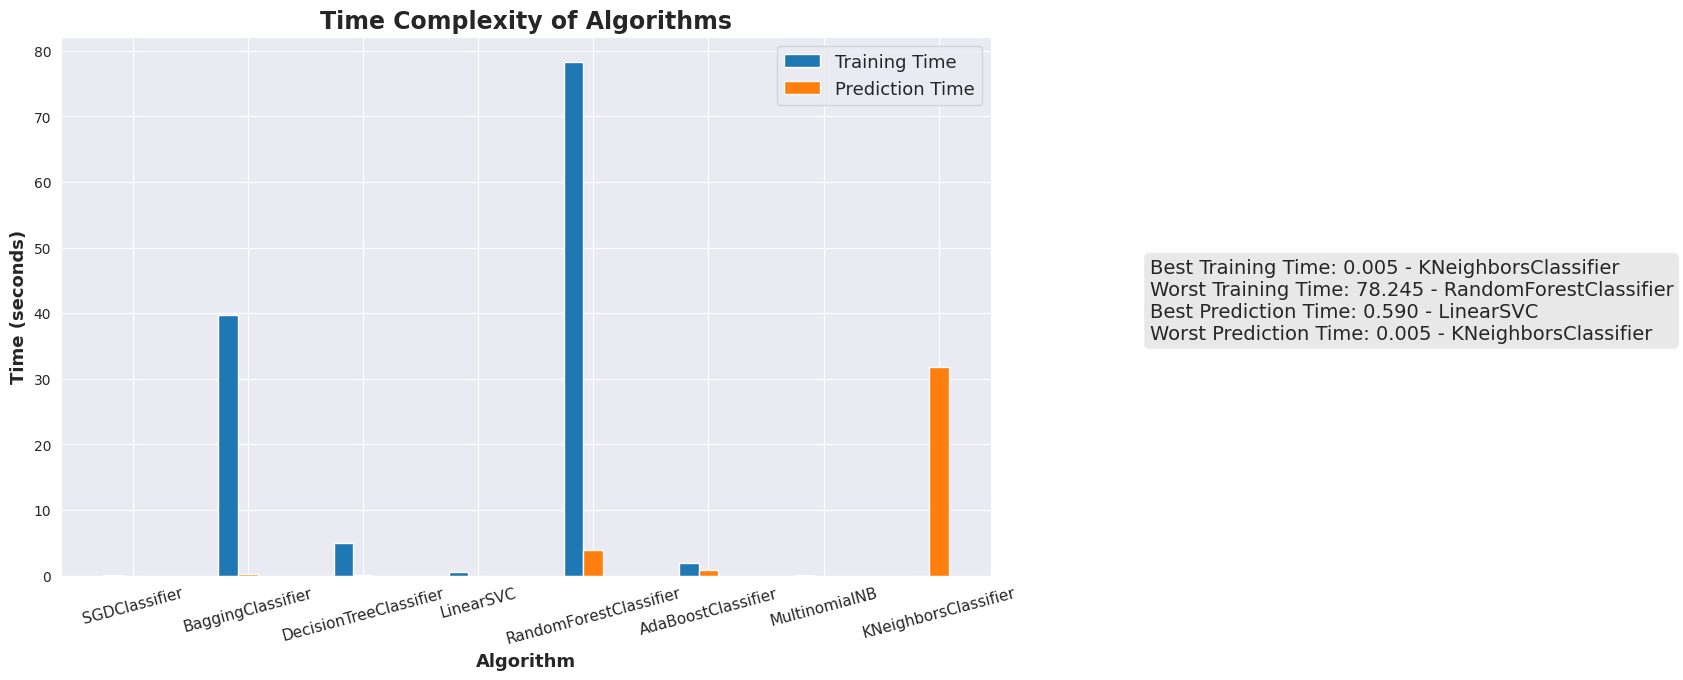

In [28]:
plt.figure(figsize = (12, 7))

barWidth = 0.17

# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')

# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)

# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]),
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]),
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9, 36, textstr, fontsize=14,  bbox=props)

plt.title('Time Complexity of Algorithms', fontweight = 'bold', fontsize = 17);

## Tuning the Hyperparameters

In [29]:
def param_tuning(clf, param_dict, X_train, y_train, X_test, y_test):

    # make scorer object
    scorer = make_scorer(f1_score)

    # perform Grid Search for Parameters
    grid_obj = GridSearchCV(estimator = clf,
                           param_grid = param_dict,
                           scoring = scorer,
                           cv = 5)

    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)

    # Report the before-and-afterscores
    print(clf.__class__.__name__)
    print("\nOptimized Model\n------")
    print("Best Parameters: {}".format(grid_fit.best_params_))
    print("Accuracy: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("F1-score: {:.4f}".format(f1_score(y_test, best_predictions)))
    print("Precision: {:.4f}".format(precision_score(y_test, best_predictions)))
    print("Recall: {:.4f}".format(recall_score(y_test, best_predictions)))

**Stochastic Gradient Classifier**

In [30]:
# Dict for parameters
param_grid = {
    'alpha' : [0.095, 0.0002, 0.0003],
    'max_iter' : [2500, 3000, 4000]
}

clf_sgd = SGDClassifier()

param_tuning(clf_sgd, param_grid, training_data, y_train, testing_data, y_test)

SGDClassifier

Optimized Model
------
Best Parameters: {'alpha': 0.0002, 'max_iter': 4000}
Accuracy: 0.9277
F1-score: 0.9436
Precision: 0.9683
Recall: 0.9201


**Decision Tree Classifier**

In [31]:
param_grid = {
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 5, 8]
}

clf_dt = DecisionTreeClassifier()

param_tuning(clf_dt, param_grid, training_data, y_train, testing_data, y_test)

DecisionTreeClassifier

Optimized Model
------
Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 5}
Accuracy: 0.9241
F1-score: 0.9416
Precision: 0.9530
Recall: 0.9304


**Random Forest Classifier**

In [33]:
param_grid = {
    'n_estimators': [50,150],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 5]
}

clf_rf = RandomForestClassifier()

param_tuning(clf_rf, param_grid, training_data, y_train, testing_data, y_test)

RandomForestClassifier

Optimized Model
------
Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Accuracy: 0.9180
F1-score: 0.9369
Precision: 0.9469
Recall: 0.9272


**Linear SVC**

In [ ]:
param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_linsvc = LinearSVC()

param_tuning(clf_linsvc, param_grid, training_data, y_train, testing_data, y_test)

### Conclusion:
***
We found Stochastic Gradient to be the best suited model for our data. We achieved the following performance parameters:
-	Accuracy: 92.81 %
-	Precision: 96.97 %
-	Recall: 91.94 %
-	F1-Score: 94.39 %



In [36]:
filename = 'cb_sgd_final.sav'
joblib.dump(clf_sgd, filename)

['cb_sgd_final.sav']